# 5-fold Cross Validation Results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch, torchvision
import mmcv
from mmcv import Config
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
import mmaction
from mmaction.apis import inference_recognizer, init_recognizer
from mmaction.datasets import build_dataset
from matplotlib import pyplot as plt
import json

import numpy as np
import decord as de
import cv2

In [28]:
dataset_dir = 'F:/ETRI-Activity3D/RGB Videos/EtriActivity3D'
dataset_name = 'EtriActivity3D'
cfg = mmcv.Config.fromfile('mmaction2/configs/recognition/timesformer/timesformer_divST_8x32x1 - modified pipeline.py')
labels = [x.strip() for x in open("label_map_EtriActivity3D.txt").readlines()]
metrics = ['top_k_accuracy', 'mean_class_accuracy']
kwargs = {} # Eval options
results = [[{}, {}] for _ in range(5)]
iter_batch_size = 5

In [26]:
def get_kwargs(cfg):
    eval_kwargs = cfg.get('evaluation', {}).copy()
    # hard-code way to remove EvalHook args
    for key in [
            'interval', 'tmpdir', 'start', 'gpu_collect', 'save_best', 'rule',
            'by_epoch'
    ]:
        eval_kwargs.pop(key, None)
    return eval_kwargs

def print_metric(cfg, metric, outputs):
    eval_kwargs = get_kwargs(cfg)
    eval_kwargs.update(dict(metrics=metric, **kwargs))
    return dataset.evaluate(outputs, **eval_kwargs)

## CV1, CV2

### 1st epoch

In [29]:
for k in [1, 2]:
    cfg.ann_file_val =  dataset_dir + '/' + dataset_name + '_test_k' + str(k) + '_video.txt'
    cfg.data.val.type = 'VideoDataset'
    cfg.data.val.ann_file = dataset_dir + '/' + dataset_name + '_test_k' + str(k) + '_video.txt'
    cfg.data.val.data_prefix = dataset_dir + '/all_videos/'
    cfg.ann_file_test =  dataset_dir + '/' + dataset_name + '_test_k' + str(k) + '_video.txt'
    cfg.data.test.type = 'VideoDataset'
    cfg.data.test.ann_file = dataset_dir + '/' + dataset_name + '_test_k' + str(k) + '_video.txt'
    cfg.data.test.data_prefix = dataset_dir + '/all_videos/'

    # results
    results_file = 'training_logs/4t entrenament/K' + str(k) + '/results_CV' + str(k) + '_epoch1.json'
    outputs = mmcv.load(results_file)

    # gt
    dataset = build_dataset(cfg.data.test)

    res = {}
    for metric in metrics:
        res.update(print_metric(cfg, metric, outputs))

    results[k-1][0] = res


Evaluating top_k_accuracy ...

top1_acc	0.8636
top5_acc	0.9899

Evaluating mean_class_accuracy ...

mean_acc	0.8589

Evaluating top_k_accuracy ...

top1_acc	0.8728
top5_acc	0.9892

Evaluating mean_class_accuracy ...

mean_acc	0.8703


### 2nd epoch

In [30]:
for k in [1, 2]:
    logs_file = "training_logs\\4t entrenament\\K" + str(k) + "\\None.log.json"

    res = []
    with open(logs_file) as f:
        for line in f.readlines():
            res.append(json.loads(line))
    res = [line for line in res if 'mode' in line]
    res_val = [line for line in res if line['mode'] == "val"]
    results[k-1][1]['top1_acc'] = res_val[0]['top1_acc']
    results[k-1][1]['top5_acc'] = res_val[0]['top5_acc']
    results[k-1][1]['mean_class_accuracy'] = res_val[0]['mean_class_accuracy']

## CV3, CV4 and CV5

In [31]:
for k in [3, 4, 5]:
    logs_file = "training_logs\\4t entrenament\\K" + str(k) + "\\None.log.json"

    res = []
    with open(logs_file) as f:
        for line in f.readlines():
            res.append(json.loads(line))
    res = [line for line in res if 'mode' in line]
    res_val = [line for line in res if line['mode'] == "val"]
    
    # 1st epoch
    results[k-1][0]['top1_acc'] = res_val[0]['top1_acc']
    results[k-1][0]['top5_acc'] = res_val[0]['top5_acc']
    results[k-1][0]['mean_class_accuracy'] = res_val[0]['mean_class_accuracy']
    
    # 2nd epoch
    results[k-1][1]['top1_acc'] = res_val[1]['top1_acc']
    results[k-1][1]['top5_acc'] = res_val[1]['top5_acc']
    results[k-1][1]['mean_class_accuracy'] = res_val[1]['mean_class_accuracy']

## Results

In [32]:
results

[[{'top1_acc': 0.8635677499556029,
   'top5_acc': 0.9899218611259102,
   'mean_class_accuracy': 0.85887991728152},
  {'top1_acc': 0.90468, 'top5_acc': 0.99609, 'mean_class_accuracy': 0.90307}],
 [{'top1_acc': 0.8728467412537737,
   'top5_acc': 0.9891671106375421,
   'mean_class_accuracy': 0.8702529914396698},
  {'top1_acc': 0.91343, 'top5_acc': 0.99547, 'mean_class_accuracy': 0.91209}],
 [{'top1_acc': 0.86823, 'top5_acc': 0.99017, 'mean_class_accuracy': 0.85713},
  {'top1_acc': 0.90708, 'top5_acc': 0.99578, 'mean_class_accuracy': 0.90596}],
 [{'top1_acc': 0.88284, 'top5_acc': 0.99245, 'mean_class_accuracy': 0.87858},
  {'top1_acc': 0.89909, 'top5_acc': 0.99574, 'mean_class_accuracy': 0.89774}],
 [{'top1_acc': 0.87627, 'top5_acc': 0.99041, 'mean_class_accuracy': 0.87577},
  {'top1_acc': 0.90601, 'top5_acc': 0.99529, 'mean_class_accuracy': 0.90047}]]

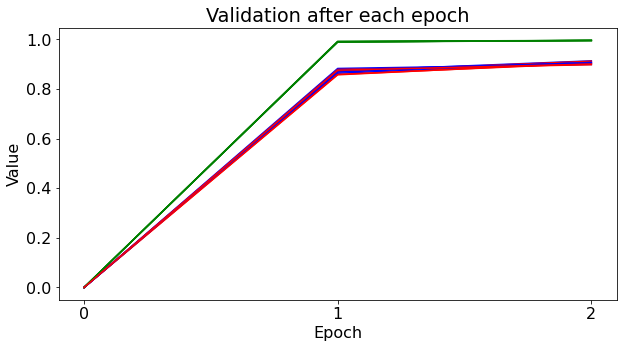

In [36]:
n_epochs = 2
for results_val in results:
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 16
    plt.plot([0] + [line['top1_acc'] for line in results_val], color='blue')
    plt.plot([0] + [line['top5_acc'] for line in results_val], color='green')
    plt.plot([0] + [line['mean_class_accuracy'] for line in results_val], color='red')
plt.title("Validation after each epoch")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(range(n_epochs + 1), [str(v) for v in range(n_epochs + 1)])
# plt.legend(loc="lower right")
plt.show()

In [43]:
print(np.mean([r[0]['top1_acc'] for r in results]), np.mean([r[1]['top1_acc'] for r in results]))

0.8727508982418752 0.906058


In [44]:
print(np.mean([r[0]['top5_acc'] for r in results]), np.mean([r[1]['top5_acc'] for r in results]))

0.9904237943526905 0.995674


In [45]:
print(np.mean([r[0]['mean_class_accuracy'] for r in results]), np.mean([r[1]['mean_class_accuracy'] for r in results]))

0.8681225817442378 0.9038660000000001
